<a href="https://colab.research.google.com/github/marathomas/meerkat/blob/master/05_Comparison_to_traditional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Embedding in traditional features

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# 4/4wF8YKpAor244IiBEBNPQMiWjTum3jvIaLSVOL5w0nVnitmIYzdv7Fc

Mounted at /content/drive


In [3]:
import os
import pandas as pd
import sys
import numpy as np
import statistics
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.legend import Legend
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc, gridspec
import matplotlib
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import umap
from scipy.stats import zscore
from sklearn import metrics
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.legend import Legend
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc, gridspec
import matplotlib
import seaborn as sns
from matplotlib.text import Annotation
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
import scipy
from scipy.spatial.distance import euclidean as euclid
from scipy.spatial import distance_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


PROJECT_PATH = "/content/drive/My Drive/meerkat/" 
FIGURES = PROJECT_PATH+"figures/"
DATA = PROJECT_PATH+"data/"

os.chdir(PROJECT_PATH)

# Load datasets

In [4]:
df_name = '2020-09-20_embedding_denoised_melspectro_focal_focal'
df = pd.read_pickle(DATA+'df_denoised_balanced')
df = df[df.nonfocal_yn == 'n'] # for focal
df.reset_index(inplace=True)

In [93]:
df.head(3)

,index,Name,Start,Duration,Time Format,Type,Description,call_yn,start_s,duration_s,stop_s,date,samplerate_hz,indv,original_wav,bout_number,call_lable,raw_audio,spectrograms,mfccs,mfcc_deltas,mfcc_deltadeltas,soundfoc_yn,stretched_spectrograms,stretched_mfccs,stretched_mfcc_deltas,stretched_mfcc_deltadeltas,denoised_spectrograms,denoised_stretched_spectrograms,denoised_mfccs,denoised_stretched_mfccs,denoised_mfcc_deltas,denoised_stretched_mfcc_deltas,certain_yn,index_id,nonfocal_yn
0,1598,ALARM,1:10:56.215,0:00.178,decimal,Cue,NaN,y,4256.215,0.178,4256.393,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,36,al,"[0.0, 0.001953125, 0.001953125, 0.0, -0.001953...","[[-7.209921, -5.1646175, -3.098959, -2.4054718...","[[-191.47098, -187.8111, -185.9428, -190.7444,...","[[-0.20289917, -0.20289917, -0.20289917, -0.20...","[[0.52968067, 0.52968067, 0.52968067, 0.529680...",n,"[[-7.011978, -9.6945915, -19.352905, -4.998459...","[[-298.56454, -287.705, -251.56706, -233.63583...","[[8.501973, 8.501973, 8.501973, 8.501973, 8.50...","[[-4.471219, -4.471219, -4.471219, -4.471219, ...","[[25.639555, 26.477575, 27.715773, 28.758339, ...","[[42.728127, 36.027912, 21.339691, 33.3617, 33...","[[16.28734, 12.311697, 8.946664, 6.3528423, 1....","[[16.01946, 1.4694939, 5.795529, 8.975101, 7.6...","[[-0.61669123, -0.61669123, -0.61669123, -0.61...","[[-1.8924303, -1.8924303, -1.8924303, -1.89243...",y,1598,n
1,1599,ALARM,1:12:04.643,0:00.317,decimal,Cue,NaN,y,4324.643,0.317,4324.960,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,37,al,"[-0.001953125, 0.0, -0.001953125, 0.001953125,...","[[-21.059677, -20.16883, -20.029144, -18.70754...","[[-202.54906, -200.67754, -198.63663, -195.151...","[[2.8926115, 2.8926115, 2.8926115, 2.8926115, ...","[[0.34753123, 0.34753123, 0.34753123, 0.347531...",n,"[[-20.856384, -25.17736, -22.190731, -18.3026,...","[[-309.39282, -302.25238, -261.8284, -244.5711...","[[9.903481, 9.903481, 9.903481, 9.903481, 9.90...","[[-5.0388603, -5.0388603, -5.0388603, -5.03886...","[[10.762169, 11.25013, 11.792789, 12.15715, 16...","[[31.449883, 24.311474, 19.03553, 20.888477, 1...","[[-1.2900445, -1.9665908, 2.6229572, 0.0544083...","[[21.421076, 10.742476, -1.0906525, 3.2950172,...","[[0.75837135, 0.75837135, 0.75837135, 0.758371...","[[-2.5341513, -2.5341513, -2.5341513, -2.53415...",y,1599,n
2,1600,ALARM,1:12:15.132,0:00.192,decimal,Cue,NaN,y,4335.132,0.192,4335.324,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,38,al,"[0.005859375, 0.005859375, 0.0078125, 0.005859...","[[-13.698711, -14.600319, -16.215317, -15.7289...","[[-228.33861, -223.5106, -216.6013, -210.05571...","[[5.747422, 5.747422, 5.747422, 5.747422, 5.74...","[[-0.56166244, -0.56166244, -0.56166244, -0.56...",n,"[[-18.871624, -18.160267, -16.079659, -15.3467...","[[-332.1619, -317.1976, -282.9387, -259.3602, ...","[[8.739941, 8.739941, 8.739941, 8.739941, 8.73...","[[-4.272333, -4.272333, -4.272333, -4.272333, ...","[[24.188335, 22.856678, 18.059265, 18.200275, ...","[[34.815525, 32.16957, 28.692219, 25.785461, 2...","[[11.280135, 13.388241, 0.17019328, 4.531397, ...","[[7.3854628, 1.116233, 0.22352138, 0.7825685, ...","[[0.3497859, 0.3497859, 0.3497859, 0.3497859, ...","[[-0.8115787, -0.8115787, -0.8115787, -0.81157...",y,1600,n


In [5]:
features = pd.read_csv(PROJECT_PATH+"data/frants/mara_features_allSNR_2.csv")

In [5]:
features.head(20)

,CALL_INDEX,Call_Type,Energy_Duration,Spectral_Entropy,Temporal_Entropy,Cepstral_Peak_Prominence,Centroid_Frequency,Peak_Frequency,lower_frequency_10dB,Upper_Frequency_10dB,Bandwidth_RMS,Bandwidth_10dB,F0_mean,F0_start,F0_mid,F0_end,SNR
0,0,sn,0.034750,4.824401,0.856071,22.450264,1380.572976,1296.8750,1195.3125,1398.4375,399.863732,203.1250,1290.178571,1296.875000,1296.875000,1273.437500,8.456472
1,10000,al,0.099750,3.278152,0.985343,24.954166,710.243646,593.7500,492.1875,687.5000,319.457257,195.3125,581.835938,621.527778,546.006944,621.961806,39.723752
2,10001,al,0.083625,4.258224,0.963011,14.768240,775.734808,671.8750,492.1875,1156.2500,306.285794,664.0625,603.222018,679.687500,572.265625,603.732639,37.009269
3,10002,al,0.082250,5.518051,0.978670,16.108639,1289.154242,632.8125,523.4375,2007.8125,814.219644,1484.3750,649.586397,744.140625,632.378472,578.993056,35.593729
4,10003,al,0.082500,4.317030,0.955606,18.933256,914.693454,601.5625,492.1875,1281.2500,438.033312,789.0625,568.295547,613.715278,535.590278,563.802083,25.857987
5,10004,al,0.080500,4.444179,0.964870,18.309922,864.201792,593.7500,476.5625,1320.3125,418.337899,843.7500,612.603082,736.328125,608.072917,501.953125,15.716379
6,10008,soc,0.321000,5.805802,0.980635,16.932032,1080.832300,757.8125,492.1875,1750.0000,492.765058,1257.8125,750.793457,658.203125,755.859375,789.062500,26.256420
7,10009,soc,0.307000,5.620627,0.985377,12.762658,939.931767,695.3125,421.8750,1531.2500,313.432877,1109.3750,689.965420,878.906250,644.531250,828.125000,25.337350
8,10010,soc,0.330625,5.629912,0.960129,13.159901,987.196453,1031.2500,468.7500,1484.3750,343.509325,1015.6250,985.795455,1062.500000,906.250000,742.187500,36.730286
9,10011,soc,0.336000,5.759491,0.983079,17.756420,1184.148278,1242.1875,367.1875,2046.8750,441.901908,1679.6875,1208.022388,992.187500,1171.875000,1445.312500,29.375650


Check for NA values

In [6]:
features.isnull().sum()

CALL_INDEX                  0
Call_Type                   0
Energy_Duration             0
Spectral_Entropy            0
Temporal_Entropy            0
Cepstral_Peak_Prominence    0
Centroid_Frequency          0
Peak_Frequency              0
lower_frequency_10dB        0
Upper_Frequency_10dB        0
Bandwidth_RMS               0
Bandwidth_10dB              0
F0_mean                     0
F0_start                    0
F0_mid                      0
F0_end                      0
SNR                         0
dtype: int64

There may have been a mixup. Check an example.

In [8]:
e = 1641
e = 24005

In [9]:
features.loc[features.CALL_INDEX==e,:]

,CALL_INDEX,Call_Type,Energy_Duration,Spectral_Entropy,Temporal_Entropy,Cepstral_Peak_Prominence,Centroid_Frequency,Peak_Frequency,lower_frequency_10dB,Upper_Frequency_10dB,Bandwidth_RMS,Bandwidth_10dB,F0_mean,F0_start,F0_mid,F0_end,SNR
3144,24005,cc,0.115875,5.399236,0.917798,13.41945,737.57166,492.1875,296.875,1117.1875,323.323152,820.3125,428.621301,414.0625,494.140625,357.638889,15.451636


In [101]:
allfiles = os.listdir(DATA+'frants_padded/')

In [102]:
print([s for s in allfiles if '1642' in s])

['padded_16421_soc.wav', 'padded_16422_soc.wav', 'padded_16423_soc.wav', 'padded_16426_soc.wav', 'padded_16427_soc.wav', 'padded_1642_agg.wav']


In [10]:
df.loc[df['index_id']==e,:].call_lable.values[0]

'cc'

Add the (potentially) correct label:

In [ ]:
call_indices = list(features.CALL_INDEX)
features['true_label'] = [df.loc[df['index_id']==ind,:].call_lable.values[0] for ind in call_indices]

In [65]:
features.loc[features.CALL_INDEX==1642,:]

,CALL_INDEX,Call_Type,Energy_Duration,Spectral_Entropy,Temporal_Entropy,Cepstral_Peak_Prominence,Centroid_Frequency,Peak_Frequency,lower_frequency_10dB,Upper_Frequency_10dB,Bandwidth_RMS,Bandwidth_10dB,F0_mean,F0_start,F0_mid,F0_end,SNR,true_label
457,1642,cc,0.121875,6.108383,0.953083,15.640821,990.35434,773.4375,296.875,1304.6875,525.770782,1007.8125,738.850911,679.6875,773.4375,896.484375,9.2202,agg


# Check if reasonable

Boxplot for different variables based on calltype

In [11]:
truth = 'true_label'
truth = 'Call_Type'

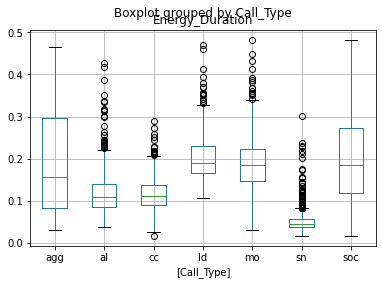

In [12]:
boxplot = features[[truth, 'Energy_Duration']].boxplot(by=truth)

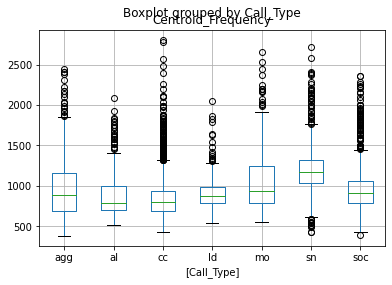

In [13]:
boxplot = features[[truth, 'Centroid_Frequency']].boxplot(by=truth)

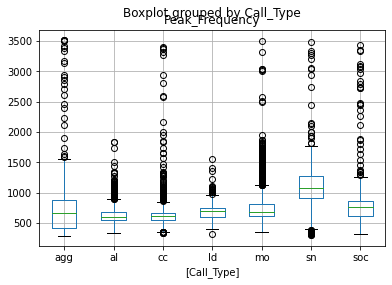

In [14]:
boxplot = features[[truth, 'Peak_Frequency']].boxplot(by=truth)

# Dimensionality reduction with features

In [6]:
embedding_dict = {}

In [7]:
def plotly_viz(method):

  embedding = embedding_dict[method]
  x, y, z = embedding[:,0], embedding[:,1], embedding[:,2] 
  scat_labels = labels
  labeltypes = sorted(list(set(scat_labels)))

  # makes colors same as AVGN visualization
  pal = sns.color_palette("Set2", n_colors=len(labeltypes))
  color_dict = dict(zip(labeltypes, pal))
  c = [color_dict[val] for val in scat_labels]

  fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                    mode='markers',
                                    hovertext = labels,
                                    marker=dict(
                                        size=4,
                                        color=c,                # set color to an array/list of desired values
                                        opacity=0.8
                                        ))])

  fig.update_layout(scene = dict(
                      xaxis_title=method+'1',
                      yaxis_title=method+'2',
                      zaxis_title=method+'3'),
                      width=700,
                      margin=dict(r=20, b=10, l=10, t=10))

  return fig

#plotly_viz("UMAP").show()

## Prepare input data

choose columns to drop

In [8]:
columns_to_drop = ['CALL_INDEX', 'Call_Type', 'SNR', 'F0_start', 'F0_mid', 'F0_end']

Choose data

In [77]:
# A) Full dataset
data = features.drop(columns=columns_to_drop)
labels = features.Call_Type
labels = data[truth]

In [107]:
# B) reduce set to only high quality (signal to noise > 10 dB)
data = features.loc[features.SNR>10,]
labels = data.Call_Type
labels = data[truth]
data = data.drop(columns=columns_to_drop)
data.shape

(5306, 11)

In [108]:
data.head(3)

,Energy_Duration,Spectral_Entropy,Temporal_Entropy,Cepstral_Peak_Prominence,Centroid_Frequency,Peak_Frequency,lower_frequency_10dB,Upper_Frequency_10dB,Bandwidth_RMS,Bandwidth_10dB,F0_mean
1,0.099750,3.278152,0.985343,24.954166,710.243646,593.7500,492.1875,687.5000,319.457257,195.3125,581.835938
2,0.083625,4.258224,0.963011,14.768240,775.734808,671.8750,492.1875,1156.2500,306.285794,664.0625,603.222018
3,0.082250,5.518051,0.978670,16.108639,1289.154242,632.8125,523.4375,2007.8125,814.219644,1484.3750,649.586397


z-transform

In [109]:
data_z = StandardScaler().fit_transform(data)

In [24]:
data = np.asarray(data)

## UMAP

In [11]:
#UMAP
reducer = umap.UMAP(low_memory=True, n_components = 10, min_dist=0)
embedding_dict['UMAP-trad'] =  reducer.fit_transform(data_z)
labels = features.loc[features.SNR>10,]['Call_Type']
plotly_viz("UMAP-trad").show()

## tSNE

In [12]:
model = TSNE(n_components=3, init='pca', random_state=0, perplexity=data.shape[0]/100, learning_rate=round(data.shape[0]/12))
embedding_dict['tSNE-trad'] = model.fit_transform(data_z) 
labels = features.loc[features.SNR>10,]['Call_Type']
plotly_viz('tSNE-trad').show()

## PCA

In [15]:
p = PCA(n_components=10, random_state=728)
p.fit(np.transpose(data))
embedding_dict['PCA-trad'] = np.transpose(p.components_)
labels = features.loc[features.SNR>10,]['Call_Type']
plotly_viz("PCA-trad").show()

# Dimensionality reduction with spectrogram

## Prepare input data

Also filter the noisy ones.

In [16]:
clean_indices = features.loc[features['SNR']>10,:].CALL_INDEX

spec_df = df[df['index_id'].isin(list(clean_indices))]
labels = spec_df.call_lable

specs = spec_df.denoised_spectrograms.values # now 2D arrays n_mels+time_frames(varying)

def pad_spectro(spec,maxlen):
  padding = maxlen - spec.shape[1]
  z = np.zeros((spec.shape[0],padding))
  padded_spec=np.append(spec, z, axis=1)
  return padded_spec

maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
#flattened_specs = [pad_spectro(spec, maxlen).flatten(order='A') for spec in specs]
specs_arr = np.asarray(flattened_specs)
data = specs_arr

# Normalize
data = StandardScaler().fit_transform(pd.DataFrame(data))

## UMAP

In [17]:
#UMAP
reducer = umap.UMAP(low_memory=True, n_components = 10, min_dist=0)
embedding_dict['UMAP'] =  reducer.fit_transform(data)
labels = spec_df.call_lable
plotly_viz("UMAP").show()

## tSNE

In [64]:
model = TSNE(n_components=3, init='pca', random_state=0, perplexity=data.shape[0]/100, learning_rate=round(data.shape[0]/12))
embedding_dict['tSNE'] = model.fit_transform(data)
labels = spec_df.call_lable
plotly_viz('tSNE').show()

# Evaluate embedding

In [25]:
embedding = embedding_dict['UMAP-trad']
labels = features.loc[features.SNR>10,]['Call_Type']


embedding = embedding_dict['UMAP']
labels = spec_df.call_lable
#embedding = data

In [29]:
k=1

# Find k nearest neighbors
nbrs = NearestNeighbors(metric='euclidean',n_neighbors=k+1, algorithm='brute').fit(embedding)
distances, indices = nbrs.kneighbors(embedding)

# need to remove the first neighbor, because that is the datapoint itself
indices = indices[:,1:]  
distances = distances[:,1:]

nn_stats_dict = {}
calltypes = sorted(list(set(labels)))
labels = np.asarray(labels)

for calltype in calltypes:
  call_indices = np.asarray(np.where(labels==calltype))[0]
  calltype_counts = np.zeros((call_indices.shape[0],len(calltypes)))

  for i,ind in enumerate(call_indices):
    nearest_neighbors = indices[ind]
    for neighbor in nearest_neighbors:
      neighbor_label = labels[neighbor]
      calltype_counts[i,np.where(np.asarray(calltypes)==neighbor_label)[0][0]] += 1 
  nn_stats_dict[calltype] = calltype_counts

# Overall frequencies
overall = np.zeros((len(calltypes)))
for i,calltype in enumerate(calltypes):
  sub_emb = embedding[labels==calltype,:]
  overall[i] = sub_emb.shape[0] 

overall = (overall/np.sum(overall))*100

stats_tab = np.zeros((len(calltypes),len(calltypes)))
stats_tab_norm = np.zeros((len(calltypes),len(calltypes)))

for i, calltype in enumerate(calltypes):
  stats = nn_stats_dict[calltype]
  stats_tab[i,:] = (np.mean(stats,axis=0)/k)*100
  stats_tab_norm[i,:] = ((np.mean(stats,axis=0)/k)*100)/overall

stats_tab = pd.DataFrame(stats_tab)
stats_tab_norm = pd.DataFrame(stats_tab_norm)

stats_tab.loc[len(stats_tab)] = overall
#stats_tab_norm.loc[len(stats_tab_norm)] = overall/overall

stats_tab.columns = calltypes
stats_tab.index = calltypes+['overall']

stats_tab_norm.columns = calltypes
stats_tab_norm.index = calltypes
x=stats_tab_norm.replace(0, 0.0001)
stats_tab_norm = np.log2(x)

Text(946.764705882353, 0.5, 'datapoint label')

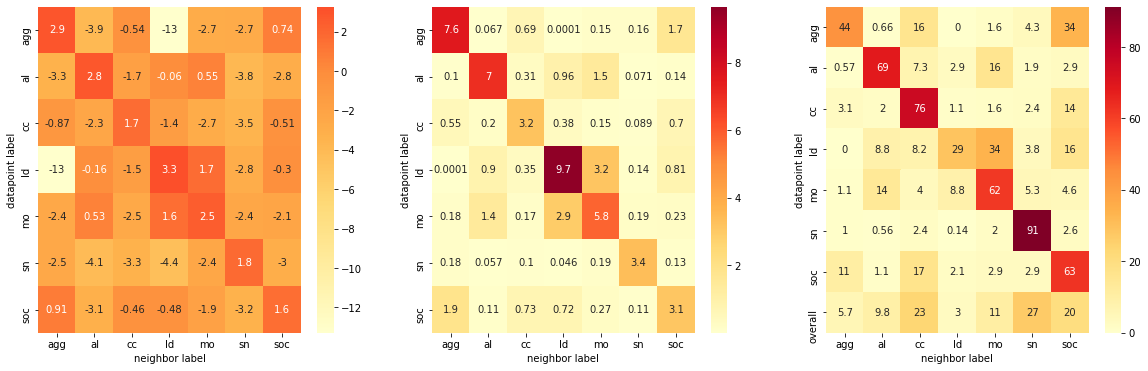

In [30]:
figurename = 'example'
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
ax=sns.heatmap(stats_tab_norm, center=0, annot=True, cmap='YlOrRd')
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
#plt.show()

# for easier interpretation: fold likelihood (x times more likely to find label in neighborhood
# than expected by chance)
plt.subplot(1, 3, 2)
ax=sns.heatmap(np.power(2,stats_tab_norm), center=5, annot=True, cmap='YlOrRd')
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
#plt.show()

plt.subplot(1, 3, 3)
ax=sns.heatmap(stats_tab, annot=True, cmap='YlOrRd')
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
#plt.show()

#plt.savefig(FIGURES+figurename)

In [31]:
print("Log final metric (unweighted):",round(np.mean(np.diagonal(stats_tab_norm))))
print("Log Final metric (weighted):",round(np.average(np.diagonal(stats_tab_norm), weights=overall),2))
print("Abs final metric (unweighted):",round(np.mean(np.diagonal(stats_tab.iloc[:-1,])),2))
print("Abs Final metric (weighted):",round(np.average(np.diagonal(stats_tab.iloc[:-1,]), weights=overall),2))

Log final metric (unweighted): 2.0
Log Final metric (weighted): 2.02
Abs final metric (unweighted): 61.9
Abs Final metric (weighted): 71.96


## k-Curve

In [ ]:
metrics_dict = {}

In [80]:
encoding = 'spectrogram'
method = 'UMAP'

embedding = embedding_dict['UMAP']
labels = spec_df.call_lable

In [85]:
encoding = 'spectrogram'
method = 'original'

clean_indices = features.loc[features['SNR']>10,:].CALL_INDEX

spec_df = df[df['index_id'].isin(list(clean_indices))]
labels = spec_df.call_lable

specs = spec_df.denoised_spectrograms.values # now 2D arrays n_mels+time_frames(varying)

def pad_spectro(spec,maxlen):
  padding = maxlen - spec.shape[1]
  z = np.zeros((spec.shape[0],padding))
  padded_spec=np.append(spec, z, axis=1)
  return padded_spec

maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
#flattened_specs = [pad_spectro(spec, maxlen).flatten(order='A') for spec in specs]
specs_arr = np.asarray(flattened_specs)
data = specs_arr

# Normalize
data = StandardScaler().fit_transform(pd.DataFrame(data))
embedding = np.asarray(data)

In [87]:
encoding = 'traditional'
method = 'UMAP'

embedding = embedding_dict['UMAP-trad']
labels = features.loc[features.SNR>10,]['Call_Type']

In [110]:
encoding = 'traditional'
method = 'original'

data = features.loc[features.SNR>10,]
labels = data.Call_Type
data = data.drop(columns=columns_to_drop)
data_z = StandardScaler().fit_transform(data)
embedding = np.asarray(data_z)

In [111]:
ks = [1,3,5,8,10,15,20,30,40]

metrics_tab = np.zeros((len(ks),4))
for k_num,k in enumerate(ks):
#k=1

  # Find k nearest neighbors
  nbrs = NearestNeighbors(metric='euclidean',n_neighbors=k+1, algorithm='brute').fit(embedding)
  distances, indices = nbrs.kneighbors(embedding)

  # need to remove the first neighbor, because that is the datapoint itself
  indices = indices[:,1:]  
  distances = distances[:,1:]

  nn_stats_dict = {}
  calltypes = sorted(list(set(labels)))
  labels = np.asarray(labels)

  for calltype in calltypes:
    call_indices = np.asarray(np.where(labels==calltype))[0]
    calltype_counts = np.zeros((call_indices.shape[0],len(calltypes)))

    for i,ind in enumerate(call_indices):
      nearest_neighbors = indices[ind]
      for neighbor in nearest_neighbors:
        neighbor_label = labels[neighbor]
        calltype_counts[i,np.where(np.asarray(calltypes)==neighbor_label)[0][0]] += 1 
    nn_stats_dict[calltype] = calltype_counts

  # Overall frequencies
  overall = np.zeros((len(calltypes)))
  for i,calltype in enumerate(calltypes):
    sub_emb = embedding[labels==calltype,:]
    overall[i] = sub_emb.shape[0] 

  overall = (overall/np.sum(overall))*100

  stats_tab = np.zeros((len(calltypes),len(calltypes)))
  stats_tab_norm = np.zeros((len(calltypes),len(calltypes)))

  for i, calltype in enumerate(calltypes):
    stats = nn_stats_dict[calltype]
    stats_tab[i,:] = (np.mean(stats,axis=0)/k)*100
    stats_tab_norm[i,:] = ((np.mean(stats,axis=0)/k)*100)/overall

  stats_tab = pd.DataFrame(stats_tab)
  stats_tab_norm = pd.DataFrame(stats_tab_norm)

  stats_tab.loc[len(stats_tab)] = overall
  #stats_tab_norm.loc[len(stats_tab_norm)] = overall/overall

  stats_tab.columns = calltypes
  stats_tab.index = calltypes+['overall']

  stats_tab_norm.columns = calltypes
  stats_tab_norm.index = calltypes
  x=stats_tab_norm.replace(0, 0.0001)
  stats_tab_norm = np.log2(x)

  metrics_tab[k_num,0] = np.mean(np.diagonal(stats_tab_norm))
  metrics_tab[k_num,1] = np.average(np.diagonal(stats_tab_norm), weights=overall)
  metrics_tab[k_num,2] = np.mean(np.diagonal(stats_tab.iloc[:-1,]))
  metrics_tab[k_num,3] = np.average(np.diagonal(stats_tab.iloc[:-1,]), weights=overall)

metrics_dict[encoding+'_'+method] = metrics_tab

In [91]:
metrics_dict.keys()

dict_keys(['spectrogram_UMAP', 'spectrogram_original', 'traditional_UMAP', 'traditional_original'])

Text(0.5, 1.0, 'Embedded space')

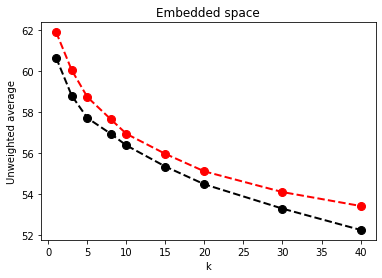

In [127]:
plt.plot(ks, metrics_dict['spectrogram_UMAP'][:,2], color='red', marker='o', linestyle='dashed',linewidth=2, markersize=8)
plt.plot(ks, metrics_dict['traditional_UMAP'][:,2], color='black', marker='o', linestyle='dashed',linewidth=2, markersize=8)
plt.ylabel("Unweighted average")
plt.xlabel("k")
plt.title("Embedded space")


Text(0.5, 1.0, 'Spectrogram approach')

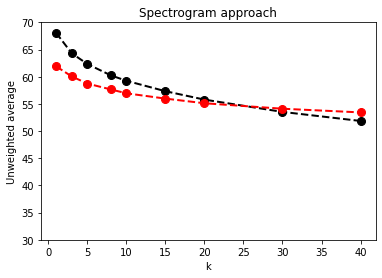

In [112]:
plt.plot(ks, metrics_dict['spectrogram_original'][:,2], color='black', marker='o', linestyle='dashed',linewidth=2, markersize=8)
plt.plot(ks, metrics_dict['spectrogram_UMAP'][:,2], color='red', marker='o', linestyle='dashed',linewidth=2, markersize=8)
plt.ylabel("Unweighted average")
plt.xlabel("k")
plt.ylim(30,70)
plt.title('Spectrogram approach')

(50.0, 70.0)

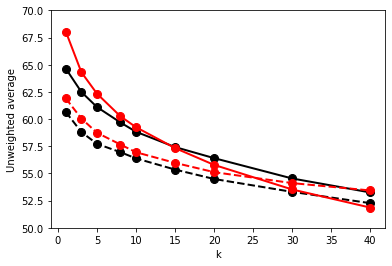

In [117]:

plt.plot(ks, metrics_dict['traditional_original'][:,2], color='black', marker='o', linewidth=2, markersize=8)
plt.plot(ks, metrics_dict['traditional_UMAP'][:,2], color='black', marker='o', linestyle='dashed',linewidth=2, markersize=8)

plt.plot(ks, metrics_dict['spectrogram_original'][:,2], color='red', marker='o', linewidth=2, markersize=8)
plt.plot(ks, metrics_dict['spectrogram_UMAP'][:,2], color='red', marker='o', linestyle='dashed',linewidth=2, markersize=8)

plt.ylabel("Unweighted average")
plt.xlabel("k")
plt.ylim(50,70)

Text(0.5, 1.0, 'Acoustic features approach')

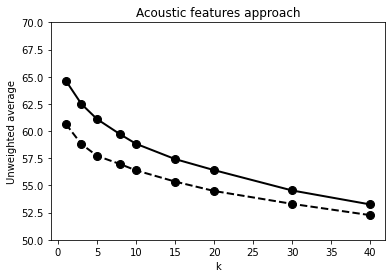

In [120]:
plt.plot(ks, metrics_dict['traditional_original'][:,2], color='black', marker='o', linewidth=2, markersize=8)
plt.plot(ks, metrics_dict['traditional_UMAP'][:,2], color='black', marker='o', linestyle='dashed',linewidth=2, markersize=8)
plt.ylabel("Unweighted average")
plt.xlabel("k")
plt.ylim(50,70)
plt.title('Acoustic features approach')

Text(0.5, 1.0, 'Spectrogram approach')

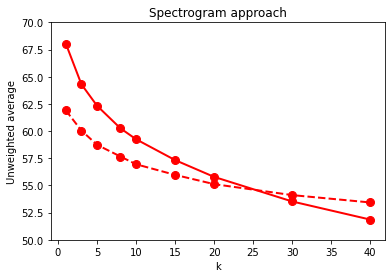

In [121]:
plt.plot(ks, metrics_dict['spectrogram_original'][:,2], color='red', marker='o', linewidth=2, markersize=8)
plt.plot(ks, metrics_dict['spectrogram_UMAP'][:,2], color='red', marker='o', linestyle='dashed',linewidth=2, markersize=8)
plt.ylabel("Unweighted average")
plt.xlabel("k")
plt.ylim(50,70)
plt.title('Spectrogram approach')